<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modelling" data-toc-modified-id="Modelling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Word2Vec-+-CNN" data-toc-modified-id="Word2Vec-+-CNN-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Word2Vec + CNN</a></span></li></ul></li></ul></div>

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Conv1D, MaxPool1D, Layer
from keras.layers import Flatten, Dropout, Input, concatenate, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model
from keras.callbacks import Callback
from keras import backend as K
import keras_metrics as km
from keras_self_attention import SeqSelfAttention

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform


import re
from ast import literal_eval

import sys
import os
import json
sys.path.append("..")

from utils.LRFinder import LRFinder
from utils.util import *

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def data():
    def load_embedding(filename):
        # load embedding into memory, skip first line
        #print("Loading Glove pre-trained model")
        # create a map of words to vectors
        embedding = dict()
        with open(filename, "r", encoding="utf-8") as file:
            for line in file:
                parts = line.split()
                word = parts[0]
                vector = np.array(parts[1:], dtype="float32")
                # key is string word, value is numpy array for vector
                embedding[word] = vector

        return embedding


    def tokenize_and_pad(docs, max_words=40):

        t = Tokenizer()
        t.fit_on_texts(docs)
        docs = pad_sequences(sequences=t.texts_to_sequences(docs), maxlen=max_words, padding='post')

        vocab = t.word_index

        return docs, vocab


    # create a weight matrix for the Embedding layer from a loaded embedding
    def get_weight_matrix(embedding, vocab, embed_dim=300):
        # total vocabulary size plus 0 for unknown words
        words_not_found = []

        vocab_size = len(vocab) + 1
        # define weight matrix dimensions with all 0
        weight_matrix = np.zeros((vocab_size, embed_dim))
        # step vocab, store vectors using the Tokenizer's integer mapping
        for word, i in vocab.items():
            embedding_vector = embedding.get(word)
            if embedding_vector is not None:
                weight_matrix[i] = embedding_vector
            else:
                words_not_found.append(word)

        return weight_matrix, words_not_found
    

    price_df = pd.read_csv("../inputs/preprocessed_news.csv")
    aux_features = ["vix", "price_change_mid", "price_change_long"]
    aux_df = price_df[aux_features]
    
    labels = price_df['signal']
    labels = pd.get_dummies(columns=['signal'], data=labels)

    docs = price_df["combined_tokens"].apply(literal_eval)
    
    docs, vocab = tokenize_and_pad(docs, max_words=35)
    embedding_index = load_embedding("../inputs/wiki-news-300d-1M-subword.vec")
    
    global embedding_matrix
    
    embedding_matrix, words_not_found = get_weight_matrix(embedding_index, vocab)
    #print(f"number of null embeddings {np.sum(np.sum(embedding_matrix, axis=1) == 0)}")
    
    
    vocab_size = len(vocab) + 1
    #print(f"vocab size = {vocab_size}")
    
    del embedding_index
    
    x_train, x_test, y_train, y_test, docs_train, docs_test = train_test_split(
        aux_df, labels, docs,
        stratify=labels,
        test_size=0.3,
        random_state=42)
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    
    return x_train, x_test, y_train, y_test, docs_train, docs_test

In [13]:
#     print(f"Shape of training docs: {x_train.shape}")
#     print(f"Shape of test docs: {x_test.shape}")
#     print(f"Shape of training labels: {y_train.shape}")
#     print(f"Shape of test labels: {y_test.shape}")

In [14]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [15]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

## Modelling

In [16]:
def visualize(result, title):
    N = result.epoch
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plt.style.use("ggplot")
    ax[0].plot(N, result.history["loss"], label="train_loss")
    ax[0].plot(N, result.history["val_loss"], label="val_loss")
    ax[1].plot(N, result.history["accuracy"], label="train_accuracy")
    ax[1].plot(N, result.history["val_accuracy"], label="val_accuracy")
    for i in range(2):
        ax[i].legend()
        ax[i].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Accuracy")
    ax[0].set_title(f"Training and Validation loss {title}")
    ax[1].set_title(f"Training and Validation Accuracy {title}")
    plt.show()

### Word2Vec + CNN

In [17]:
x_train, x_test, y_train, y_test, docs_train, docs_test = data()

In [20]:
def cnn_model(x_train, y_train, docs_train):
    input = Input(shape=(docs_train.shape[-1],), name="word_input")
    word_emb = Embedding(input_dim=embedding_matrix.shape[0],
                         output_dim=embedding_matrix.shape[-1],
                         weights=[embedding_matrix],
                         input_length = docs_train.shape[-1],
                         trainable=False,
                         name="word_embedding_layer")(input)
    convs = []
    filter_sizes = [3, 4, 5]
    for filter_size in filter_sizes:
        conv_l = Conv1D(filters=256, kernel_size=filter_size , 
                        activation="relu")(word_emb)
        pool_l = MaxPool1D(pool_size=2)(conv_l)
        convs.append(pool_l)
    
    merge_l = concatenate(convs, axis=1)
    main = Flatten()(merge_l)
    aux_input = Input(shape=(x_train.shape[-1],), name="aux_input")
    concat = concatenate([main, aux_input])
    hidden_2 = Dense(128, activation="relu")(concat)
    hidden_2 = Dropout(0.4)(hidden_2)
    hidden_3 = Dense(128, activation="relu")(hidden_2)
    hidden_3 = Dropout(0.4)(hidden_3)

    output_layer = Dense(y_train.shape[-1], activation="sigmoid", name="output")(hidden_3)
    
    model = Model(inputs=[input, aux_input], outputs=[output_layer], name="cnn")
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1])
    
    return model

In [8]:
def cnn_tune(x_train, x_test, y_train, y_test, docs_train, docs_test):
    
    input = Input(shape=(docs_train.shape[-1],), name="word_input")
    word_emb = Embedding(input_dim=embedding_matrix.shape[0],
                         output_dim=embedding_matrix.shape[-1],
                         weights=[embedding_matrix],
                         input_length = docs_train.shape[-1],
                         trainable=False,
                         name="word_embedding_layer")(input)
    convs = []
    filter_sizes = [3, 4, 5]
    
    for filter_size in filter_sizes:
        conv_l = Conv1D(filters={{choice([2, 4, 6])}}, kernel_size=filter_size , 
                        activation="relu")(word_emb)
        pool_l = MaxPool1D(pool_size={{choice([5, 6, 7, 8])}})(conv_l)
        convs.append(pool_l)
    
    merge_l = concatenate(convs, axis=1)
    merge_drop_l = Dropout({{uniform(0.1, 0.7)}})(merge_l)
    main = Flatten()(merge_drop_l)
    aux_input = Input(shape=(x_train.shape[-1],), name="aux_input")
    concat = concatenate([main, aux_input])
    hidden_2 = Dense(128, activation="relu")(concat)
    hidden_2 = Dropout({{uniform(0.2, 0.7)}})(hidden_2)
    hidden_3 = Dense(128, activation="relu")(hidden_2)
    hidden_3 = Dropout({{uniform(0.2, 0.7)}})(hidden_3)

    output_layer = Dense(y_train.shape[-1], activation="sigmoid", name="output")(hidden_3)
    
    model = Model(inputs=[input, aux_input], outputs=[output_layer], name="cnn")
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1])
    
    early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)
    
    
    result = model.fit([docs_train, x_train], y_train,
                       batch_size=32,
                       epochs=50,
                       verbose=0,
                       validation_split=0.2,
                       callbacks=[early_stopping_cb])
    
    validation_acc = np.amax(result.history["val_accuracy"])
    validation_f1 = np.amax(result.history["val_f1"])
    
    print(f"Best validation acc {validation_acc}, validation_f1 {validation_f1}.")
    
    return {"loss": -validation_f1, "status": STATUS_OK, "model": model}


In [9]:
best_run_cnn, best_model_cnn = optim.minimize(model=cnn_tune,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=20,
                                      trials=Trials(),
                                      eval_space=True,
                                      notebook_name="Hyperparameter-Tuning")

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from keras.preprocessing.text import Tokenizer
except:
    pass

try:
    from keras.preprocessing.sequence import pad_sequences
except:
    pass

try:
    from keras.layers import Dense, LSTM, Embedding, Bidirectional, Conv1D, MaxPool1D, Layer
except:
    pass

try:
    from keras.layers import Flatten, Dropout, Input, concatenate, BatchNormalization, Activation
except:
    pass

try:
    from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
except:
    pass

try:
    from keras import initializers, regularizers, constraints, optimizers, layers
except:
    pass



W0926 23:01:05.982304  6008 deprecation_wrapper.py:119] From C:\Users\andre\Anaconda3\envs\data-science\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.


W0926 23:01:06.061083  6008 nn_ops.py:4224] Large dropout rate: 0.568585 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.

W0926 23:01:06.085029  6008 nn_ops.py:4224] Large dropout rate: 0.525898 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.

W0926 23:01:06.236601  6008 deprecation.py:323] From C:\Users\andre\Anaconda3\envs\data-science\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Best validation acc 0.647310197353363, validation_f1 0.6597491502761841.                                               
  5%|██▌                                                | 1/20 [00:28<09:10, 28.96s/it, best loss: -0.6597491502761841]

W0926 23:01:34.694012  6008 nn_ops.py:4224] Large dropout rate: 0.6862 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.

W0926 23:01:34.722935  6008 nn_ops.py:4224] Large dropout rate: 0.618333 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.

W0926 23:01:34.743901  6008 nn_ops.py:4224] Large dropout rate: 0.656415 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.



Best validation acc 0.6468074321746826, validation_f1 0.6588607430458069.                                              
Best validation acc 0.6488184928894043, validation_f1 0.6568068265914917.                                              
Best validation acc 0.6458019018173218, validation_f1 0.6559796333312988.                                              
Best validation acc 0.6500754356384277, validation_f1 0.660312831401825.                                               
Best validation acc 0.6478129625320435, validation_f1 0.6604928374290466.                                              
Best validation acc 0.6458019018173218, validation_f1 0.6587222218513489.                                              
Best validation acc 0.6390146017074585, validation_f1 0.6544899940490723.                                              
Best validation acc 0.6468074321746826, validation_f1 0.6602743268013.                                                 
Best validation acc 0.6458019018173218, 

In [10]:

print("Evalutation of best performing model:")
print(best_model_cnn.evaluate([docs_test, x_test],y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run_cnn)

Evalutation of best performing model:
4973/4973 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 74us/step
[0.822622916826942, 0.6450834274291992, 0.6644793748855591]
Best performing model chosen hyper-parameters:
{'Dropout': 0.35325333987142893, 'Dropout_1': 0.656281059431072, 'Dropout_2': 0.2930424842903513, 'filters': 4, 'pool_size': 6}


In [11]:
best_run_cnn

{'Dropout': 0.35325333987142893,
 'Dropout_1': 0.656281059431072,
 'Dropout_2': 0.2930424842903513,
 'filters': 4,
 'pool_size': 6}

In [12]:
best_model_cnn.save("../saved_models/tuned_cnn_model_fast_text.h5")

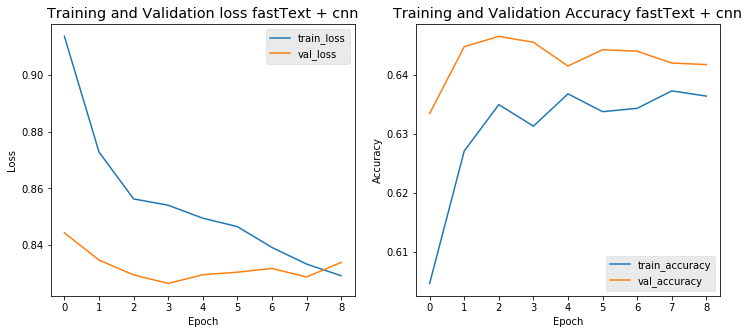

In [13]:
results_cnn = best_model_cnn.history
visualize(results_cnn, "fastText + cnn")

In [83]:
def lstm_model(x_train, y_train, docs_train):
    input = Input(shape=(docs_train.shape[-1],), name="word_input")
    word_emb = Embedding(input_dim=embedding_matrix.shape[0],
                         output_dim=embedding_matrix.shape[-1],
                         weights=[embedding_matrix],
                         input_length = docs_train.shape[-1],
                         trainable=False,
                         name="word_embedding_layer")(input)

    lstml_1 = Bidirectional(LSTM(units=2,
                                 dropout=0.2,
                                 return_sequences=False))(word_emb)
    aux_input = Input(shape=(x_train.shape[-1],), name="aux_input")
    concat = concatenate([lstml_1, aux_input])
    hidden_2 = Dense(128, activation="relu")(concat)
    hidden_2 = Dropout(0.4)(hidden_2)
    hidden_3 = Dense(128, activation="relu")(hidden_2)
    hidden_3 = Dropout(0.4)(hidden_3)
    output_layer = Dense(y_train.shape[-1], activation="sigmoid", name="output")(hidden_3)
    
    model = Model(inputs=[input, aux_input], outputs=[output_layer], name="lstm")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1])
    
    return model

In [14]:
def lstm_tune(x_train, x_test, y_train, y_test, docs_train, docs_test):
    
    input = Input(shape=(docs_train.shape[-1],), name="word_input")
    word_emb = Embedding(input_dim=embedding_matrix.shape[0],
                         output_dim=embedding_matrix.shape[-1],
                         weights=[embedding_matrix],
                         input_length = docs_train.shape[-1],
                         trainable=False,
                         name="word_embedding_layer")(input)

    lstml_1 = Bidirectional(LSTM(units={{choice([25, 50, 75, 100])}},
                                 dropout={{uniform(0.1, 0.7)}},
                                 return_sequences=False))(word_emb)
    
    aux_input = Input(shape=(x_train.shape[-1],), name="aux_input")
    concat = concatenate([lstml_1, aux_input])
    hidden_2 = Dense(128, activation="relu")(concat)
    hidden_2 = Dropout({{uniform(0.2, 0.7)}})(hidden_2)
    hidden_3 = Dense(128, activation="relu")(hidden_2)
    hidden_3 = Dropout({{uniform(0.2, 0.7)}})(hidden_3)
    output_layer = Dense(y_train.shape[-1], activation="sigmoid", name="output")(hidden_3)
    
    model = Model(inputs=[input, aux_input], outputs=[output_layer], name="lstm")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1])
    
    early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)
    
    
    result = model.fit([docs_train, x_train], y_train,
                       batch_size=32,
                       epochs=50,
                       verbose=0,
                       validation_split=0.2,
                       callbacks=[early_stopping_cb])
    
    validation_acc = np.amax(result.history["val_accuracy"])
    validation_f1 = np.amax(result.history["val_f1"])
    print(f"Best validation acc {validation_acc} and validation f1 {validation_f1} of epoch.")
    
    return {"loss": -validation_f1, "status": STATUS_OK, "model": model}


In [15]:
best_run_lstm, best_model_lstm = optim.minimize(model=lstm_tune,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=20,
                                      trials=Trials(),
                                      eval_space=True,
                                      notebook_name="Hyperparameter-Tuning")


>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from keras.preprocessing.text import Tokenizer
except:
    pass

try:
    from keras.preprocessing.sequence import pad_sequences
except:
    pass

try:
    from keras.layers import Dense, LSTM, Embedding, Bidirectional, Conv1D, MaxPool1D, Layer
except:
    pass

try:
    from keras.layers import Flatten, Dropout, Input, concatenate, BatchNormalization, Activation
except:
    pass

try:
    from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
except:
    pass

try:
    from keras import initializers, regularizers, constraints, optimizers, layers
except:
    pass


In [16]:
print("Evalutation of best performing model:")
print(best_model_lstm.evaluate([docs_test, x_test],y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run_lstm)

Evalutation of best performing model:
4973/4973 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 632us/step
[0.8258167697753845, 0.6408606767654419, 0.6611457467079163]
Best performing model chosen hyper-parameters:
{'Dropout': 0.20874716804341903, 'Dropout_1': 0.20585045867230478, 'dropout': 0.2732481963921828, 'units': 50}


In [18]:
best_model_lstm.save("../saved_models/lstm_model_fast_text.h5")

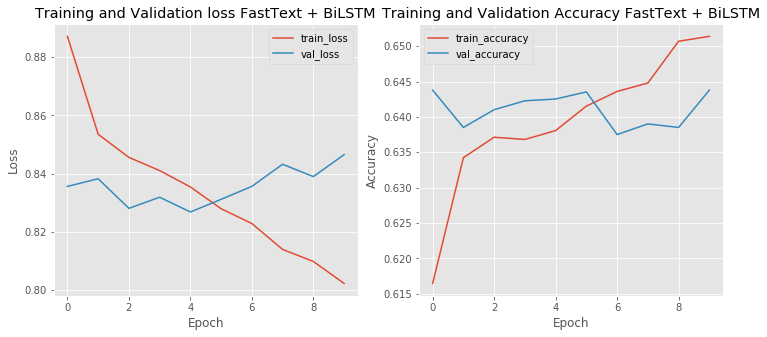

In [20]:
result_lstm = best_model_lstm.history
visualize(result_lstm, "FastText + BiLSTM")

In [21]:
def attention_lstm_model(x_train, x_test, y_train, y_test, docs_train, docs_test):

    input = Input(shape=(docs_train.shape[-1],), name="word_input")
    word_emb = Embedding(input_dim=embedding_matrix.shape[0],
                         output_dim=embedding_matrix.shape[-1],
                         weights=[embedding_matrix],
                         input_length = docs_train.shape[-1],
                         trainable=False,
                         name="word_embedding_layer")(input)

    lstml_1 = Bidirectional(LSTM(units={{choice([32, 64, 128])}}, 
                                 dropout={{uniform(0.1, 0.7)}},
                                 return_sequences=True))(word_emb)
    self_attention = SeqSelfAttention(attention_activation='sigmoid')(lstml_1)
    self_attention_flatten = Flatten()(self_attention)
    
    aux_input = Input(shape=(x_train.shape[-1],), name="aux_input")
    concat = concatenate([self_attention_flatten, aux_input])
    hidden_2 = Dense(128, activation="relu")(concat)
    hidden_2 = Dropout({{uniform(0.2, 0.7)}})(hidden_2)
    hidden_3 = Dense(128, activation="relu")(hidden_2)
    hidden_3 = Dropout({{uniform(0.2, 0.7)}})(hidden_3)
    output_layer = Dense(y_train.shape[-1], activation="sigmoid", name="output")(hidden_3)

    model = Model(inputs=[input, aux_input], outputs=[output_layer], name="lstm")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1])
    
    early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)
    
    
    result = model.fit([docs_train, x_train], y_train,
                       batch_size=32,
                       epochs=50,
                       verbose=0,
                       validation_split=0.2,
                       callbacks=[early_stopping_cb])
    
    validation_acc = np.amax(result.history["val_accuracy"])
    validation_f1 = np.amax(result.history["val_f1"])
    
    print(f"Best validation acc {validation_acc}, validation_f1 {validation_f1}.")
    
    return {"loss": -validation_f1, "status": STATUS_OK, "model": model}

    

In [22]:
best_run_attention_lstm, best_model_attention_lstm = optim.minimize(model=attention_lstm_model,
                                                                    data=data,
                                                                    algo=tpe.suggest,
                                                                    max_evals=20,
                                                                    trials=Trials(),
                                                                    eval_space=True,
                                                                    notebook_name="Hyperparameter-Tuning")

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from keras.preprocessing.text import Tokenizer
except:
    pass

try:
    from keras.preprocessing.sequence import pad_sequences
except:
    pass

try:
    from keras.layers import Dense, LSTM, Embedding, Bidirectional, Conv1D, MaxPool1D, Layer
except:
    pass

try:
    from keras.layers import Flatten, Dropout, Input, concatenate, BatchNormalization, Activation
except:
    pass

try:
    from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
except:
    pass

try:
    from keras import initializers, regularizers, constraints, optimizers, layers
except:
    pass


In [23]:
x_train, x_test, y_train, y_test, docs_train, docs_test = data()
print("Evalutation of best performing model:")
print(best_model_attention_lstm.evaluate([docs_test, x_test],y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run_attention_lstm)

Evalutation of best performing model:
4973/4973 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 672us/step
[0.825047572182142, 0.6458877921104431, 0.6640523076057434]
Best performing model chosen hyper-parameters:
{'Dropout': 0.2924657061733502, 'Dropout_1': 0.45531035147751703, 'dropout': 0.2761147295123246, 'units': 64}


In [24]:
result_attention_lstm = best_model_attention_lstm.history

In [27]:
best_model_attention_lstm.save("../saved_models/tuned_attBilstm_fast_text.h5")

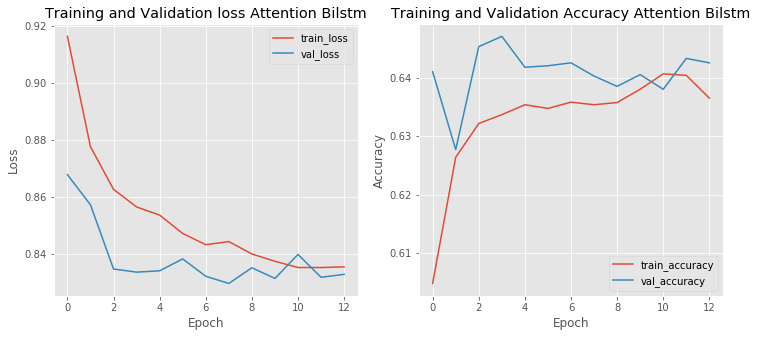

In [26]:
visualize(result_attention_lstm, "Attention Bilstm")